# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import subprocess

In [2]:
packages = ['nltk', 'spacy', 'lightgbm']

for package in packages:
    try:
        output = subprocess.check_output(f'pip show {package}', shell=True)
        version = output.decode().split('\n')[1].split(': ')[1]
        print(f'{package} установлена, версия: {version}')
    except subprocess.CalledProcessError:
        print(f'{package} не установлена')

nltk установлена, версия: 3.8.1
spacy установлена, версия: 3.7.2
lightgbm установлена, версия: 4.3.0


In [3]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords as nltk_stopwords
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score

from multiprocessing import Pool, Manager
from tqdm.auto import tqdm

from joblib import Parallel, delayed

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
try: 
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('<link>')

In [5]:
display(df.head())
df.info()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
df = df.drop('Unnamed: 0', axis=1)

In [7]:
dupl_df = df.duplicated().sum()
dupl_text = df['text'].duplicated().sum()

In [8]:
print(f' Кол-во дублирующихся строк: {dupl_df}')
print(f' Кол-во дублирующихся строк:{dupl_text}')


 Кол-во дублирующихся строк: 0
 Кол-во дублирующихся строк:0


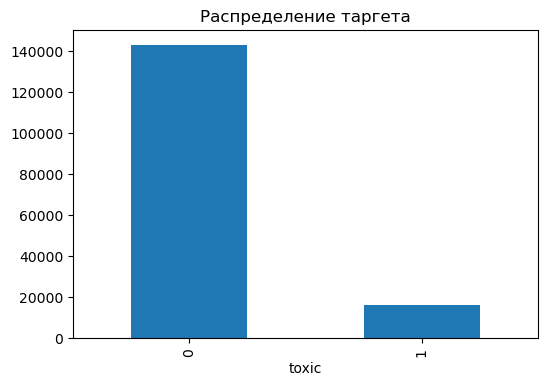

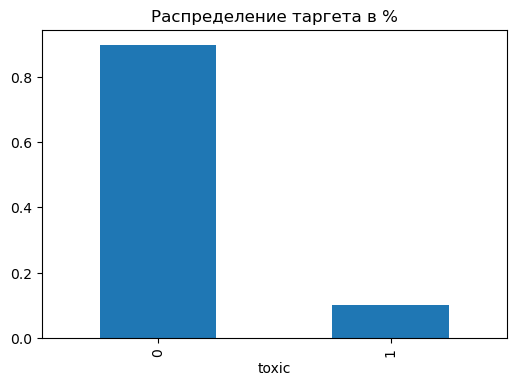

In [9]:
plt.figure(figsize=(6,4))
df['toxic'].value_counts().plot(kind='bar')
plt.title('Распределение таргета')
plt.show()
plt.figure(figsize=(6,4))
df['toxic'].value_counts(normalize=True).plot(kind='bar')
plt.title('Распределение таргета в %')
plt.show()

<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Промежуточный вывод:</strong>   <br><br>
• Из графиков видно, что есть дисбаланс классов 9:1 в пользу не токсичных комментариев, нужно будет учесть при разбиении   <br><br>
• Дубликатов и пропусков в строках не обнаружено <br><br>
• Удален дублирующий индексы столбец  
</p>
</div>

In [10]:
#Приведем к нижнему регистру
df['text']=df['text'].str.lower()

In [12]:
disabled_pipes = ["parser",  "ner"]
nlp = spacy.load('en_core_web_sm', disable=disabled_pipes)
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.is_alpha]
    return " ".join(lemmas)

In [14]:
df = df.copy()

In [29]:
def lemmatize(text):
    '''Функция для лемматизации текста'''
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.is_alpha]
    return " ".join(lemmas)

def process_part(data):
    '''Функция для обработки части DataFrame'''
    df_part, progress_queue = data
    results = []
    for text in df_part['text']:
        lemmatized_text = lemmatize(text)
        results.append(lemmatized_text)
        progress_queue.put(1)  
    df_part['lemm_text'] = results
    return df_part

def parallelize_dataframe(df, func, n_cores=4):
    '''Функция для распараллеливания обработки'''
    manager = Manager()
    progress_queue = manager.Queue()  
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    tasks = [(part, progress_queue) for part in df_split]
    result_async = pool.map_async(func, tasks)
    
    pbar = tqdm(total=len(df))
    try:
        while not result_async.ready():
            while not progress_queue.empty():
                pbar.update(progress_queue.get())
            result_async.wait(timeout=0.1)  
    finally:
        pbar.close()  
        pool.close()
        pool.join()
    
    return pd.concat(result_async.get())



df_processed = parallelize_dataframe(df, process_part)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [30]:
df_processed.head()

,text,toxic,lemm_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,d'aww! he matches this background colour i'm s...,0,he match this background colour I seemingly st...
2,"hey man, i'm really not trying to edit war. it...",0,hey man I really not try to edit war it just t...
3,"""\nmore\ni can't make any real suggestions on ...",0,more I can make any real suggestion on improve...
4,"you, sir, are my hero. any chance you remember...",0,you sir be my hero any chance you remember wha...


In [32]:
df_processed.sample(5)

,text,toxic,lemm_text
158122,"btw, 250 000 died in the war, not 100 000! i h...",0,btw die in the war not I have change that
52890,"""\n\n request for a complete export of one art...",0,request for a complete export of one article a...
13780,you will not shut me or alun up with sludge-ta...,1,you will not shut I or alun up with sludge tal...
2328,1997 domestic grosses \nbatman and robin warne...,0,domestic gross batman and robin warner bros to...
15207,"what i do not understand is, if i am told i ca...",0,what I do not understand be if I be tell I can...


In [33]:
df_processed.tail()

,text,toxic,lemm_text
159287,""":::::and for the second time of asking, when ...",0,and for the second time of asking when your vi...
159288,you should be ashamed of yourself \n\nthat is ...,0,you should be ashamed of yourself that be a ho...
159289,"spitzer \n\numm, theres no actual article for ...",0,spitzer umm there s no actual article for pros...
159290,and it looks like it was actually you who put ...,0,and it look like it be actually you who put on...
159291,"""\nand ... i really don't think you understand...",0,and I really do think you understand I come he...


<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Промежуточный вывод:</strong>   <br><br>
• Была проведена лемматизация и очистка с помощью библиотеки spacy. По 5 первым, 5 случайным и 5 конечным - убедились, что преобразовано все верно  <br><br>

   
</p>
</div>

## Обучение

In [34]:
features,target = df_processed['lemm_text'],df_processed['toxic']
 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=0xEDA)

nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))

tf_idf = TfidfVectorizer(preprocessor=lambda x: x.lower(),stop_words=stopwords) 


[nltk_data] Downloading package stopwords to /home/pt1c4/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
%%time

lgbm_classifier = LGBMClassifier(class_weight='balanced',random_state=0xEDA)

lgbm_params = {
                'lgbm__learning_rate' : [0.14,0.2],
                'lgbm__max_depth' : [-1],
                'lgbm__n_estimators' : [700,750]
              }
pipeline1 = Pipeline([
    ('tfidf', tf_idf),
    ('lgbm', lgbm_classifier)
])

lgbm_model = RandomizedSearchCV(estimator=pipeline1, 
                                param_distributions=lgbm_params, 
                                random_state=0xEDA, 
                                n_jobs=-1,
                                scoring='f1',
                                cv=3,verbose=1)

lgbm_model.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Info] Number of positive: 14565, number of negative: 128797
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 7.350072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571897
[LightGBM] [Info] Number of data points in the train set: 143362, number of used features: 10317
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
CPU times: user 7min 52s, sys: 20.8 s, total: 8min 12s
Wall time: 28min 29s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(preprocessor=<function <lambda> at 0x7bd8a138aac0>,
                                                              stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'ours',
                                                                          'ourselves',
                                                                          'you',
                                                                          "you're",
                                                                          "you've",
                                                                          "you'll",
                                                                          "you'd",
                                                                          'your',
                                                                          'yours',
                                                                          'yourself',
                                                                          'yourselves',
                                                                          'he',
                                                                          'him',
                                                                          'his',
                                                                          'himself',
                                                                          'she',
                                                                          "she's",
                                                                          'her',
                                                                          'hers',
                                                                          'herself',
                                                                          'it',
                                                                          "it's",
                                                                          'its',
                                                                          'itself', ...])),
                                             ('lgbm',
                                              LGBMClassifier(class_weight='balanced',
                                                             random_state=3802))]),
                   n_jobs=-1,
                   param_distributions={'lgbm__learning_rate': [0.14, 0.2],
                                        'lgbm__max_depth': [-1],
                                        'lgbm__n_estimators': [700, 750]},
                   random_state=3802, scoring='f1', verbose=1)

In [36]:
print(f'Лучший скор: {lgbm_model.best_score_}')
print(lgbm_model.best_params_)

Лучший скор: 0.7681828784991347
{'lgbm__n_estimators': 700, 'lgbm__max_depth': -1, 'lgbm__learning_rate': 0.2}


In [37]:
%%time

rf_classifier = RandomForestClassifier(class_weight='balanced',random_state=0xEDA, n_jobs=-1 )

rf_params = {
                'rf__n_estimators': [i for i in range(70, 82, 10)],
                'rf__max_depth': [i for i in range(16, 18, 1)],
            }

pipeline2 = Pipeline([
    ('tfidf', tf_idf),
    ('rf', rf_classifier)
])

rf_model = RandomizedSearchCV(estimator=pipeline2, 
                              param_distributions=rf_params, 
                              random_state=0xEDA, 
                              n_jobs=-1,
                              scoring='f1',
                              cv=3,verbose=1)

rf_model.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: user 18.7 s, sys: 655 ms, total: 19.4 s
Wall time: 1min 4s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(preprocessor=<function <lambda> at 0x7bd8a138aac0>,
                                                              stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'ours',
                                                                          'ourselves',
                                                                          'you',
                                                                          "you're",
                                                                          "you've",
                                                                          "you'll",
                                                                          "you'd",
                                                                          'your',
                                                                          'yours',
                                                                          'yourself',
                                                                          'yourselves',
                                                                          'he',
                                                                          'him',
                                                                          'his',
                                                                          'himself',
                                                                          'she',
                                                                          "she's",
                                                                          'her',
                                                                          'hers',
                                                                          'herself',
                                                                          'it',
                                                                          "it's",
                                                                          'its',
                                                                          'itself', ...])),
                                             ('rf',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     random_state=3802))]),
                   n_jobs=-1,
                   param_distributions={'rf__max_depth': [16, 17],
                                        'rf__n_estimators': [70, 80]},
                   random_state=3802, scoring='f1', verbose=1)

In [38]:
print(f'Лучший скор:{rf_model.best_score_}')
print(rf_model.best_params_)

best_rf_model = rf_model.best_estimator_
best_lgbm_model = lgbm_model.best_estimator_

Лучший скор:0.3817305287972414
{'rf__n_estimators': 80, 'rf__max_depth': 17}


In [39]:
#предсказывание по лучшим параметрам LGBM
rf_predict = best_rf_model.predict(X_test)
lgbm_predict = best_lgbm_model.predict(X_test)

print('LGBM',f1_score(y_test, lgbm_predict))


LGBM 0.7729666471620831
[LightGBM] [Info] Number of positive: 9710, number of negative: 85864
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 12.017889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427963
[LightGBM] [Info] Number of data points in the train set: 95574, number of used features: 7985
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 9710, number of negative: 85865
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 10.460565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429192
[LightGBM] [Info] Number of data points in the train set: 95575, number of used features: 8037
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training fr

## Выводы

<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Вывод:</strong>   <br>
  <br>
Были построены две модели - Random Forest и LGBM, для них подобраны гиперпараметры на кросс валидации со взвешенным таргетом. После валидации была отобрана модель LGBM(0.77), так как ее качество почти в 2 раза превосходит Random Forest(0.38) и оно входит в допустимую погрешность заданную в задании. На тесте переобучения выявлено не было, качество модели LGBM(0.77) так же удовлетворяет погрешности.
   
</p>
</div>